# Temperature VS lexical diversity and coherence

## Setup

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from text_analysis import process_model_data, calculate_temperature_stats, plot_single_model_metrics, plot_combined_models_metrics

In [3]:
# Load model
sbert_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

## gpt-4.1

In [4]:
# Load and process OpenAI data
with open('results/results_openai.json', 'r', encoding='utf-8') as f:
    raw_data_openai = json.load(f)

df_openai = pd.DataFrame(raw_data_openai)
analysis_df_openai = process_model_data(df_openai, sbert_model, "OpenAI")
temp_stats_openai = calculate_temperature_stats(analysis_df_openai)

Processing 630 samples for OpenAI...
  Processed 0/630 samples...
  Processed 100/630 samples...
  Processed 200/630 samples...
  Processed 300/630 samples...
  Processed 400/630 samples...
  Processed 500/630 samples...
  Processed 600/630 samples...
✓ Analyzed 630 samples for OpenAI
  Temperature distribution: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


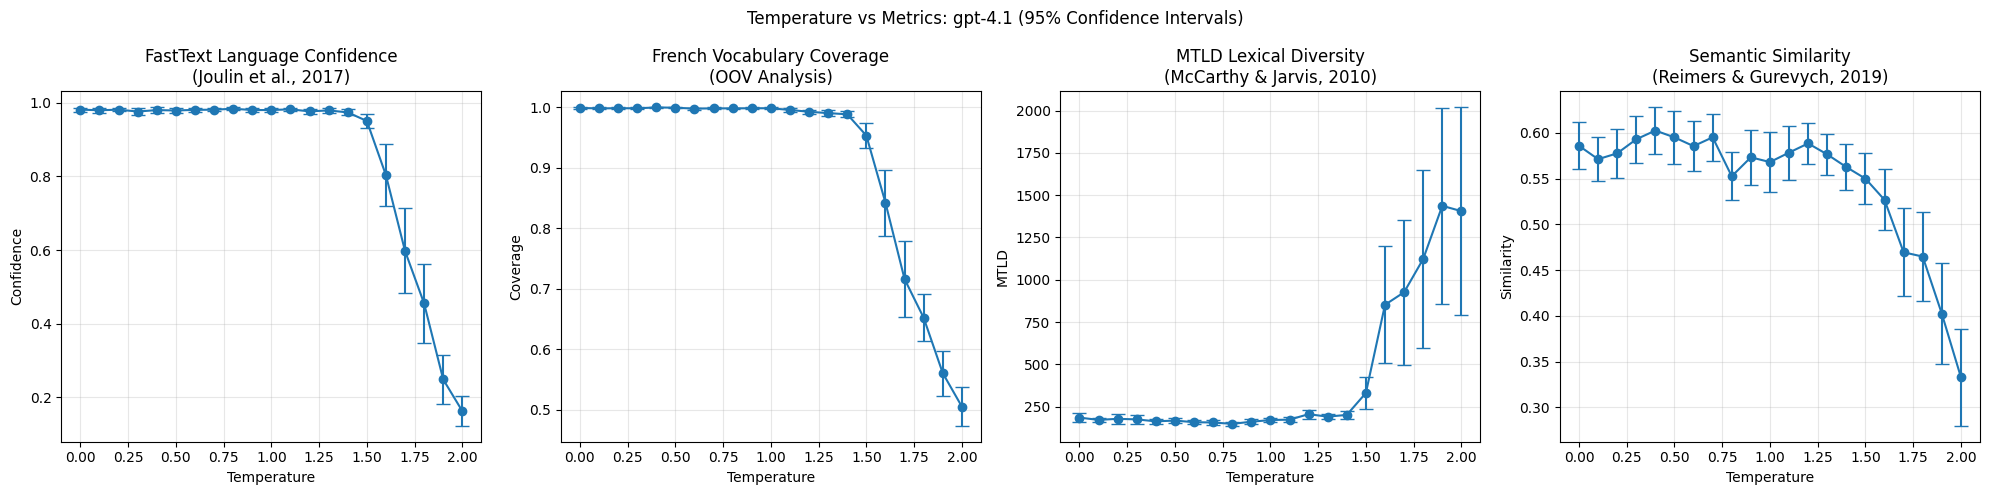

In [9]:
fig, axes = plot_single_model_metrics(temp_stats_openai, "gpt-4.1", use_ci=True)
plt.show()

## mistral-medium

In [10]:
# Load and process Mistral data
with open('results/results_mistral.json', 'r', encoding='utf-8') as f:
    raw_data_mistral = json.load(f)

df_mistral = pd.DataFrame(raw_data_mistral)
analysis_df_mistral = process_model_data(df_mistral, sbert_model, "Mistral")
temp_stats_mistral = calculate_temperature_stats(analysis_df_mistral)

Processing 480 samples for Mistral...
  Processed 0/480 samples...
  Processed 100/480 samples...
  Processed 200/480 samples...
  Processed 300/480 samples...
  Processed 400/480 samples...
✓ Analyzed 480 samples for Mistral
  Temperature distribution: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]


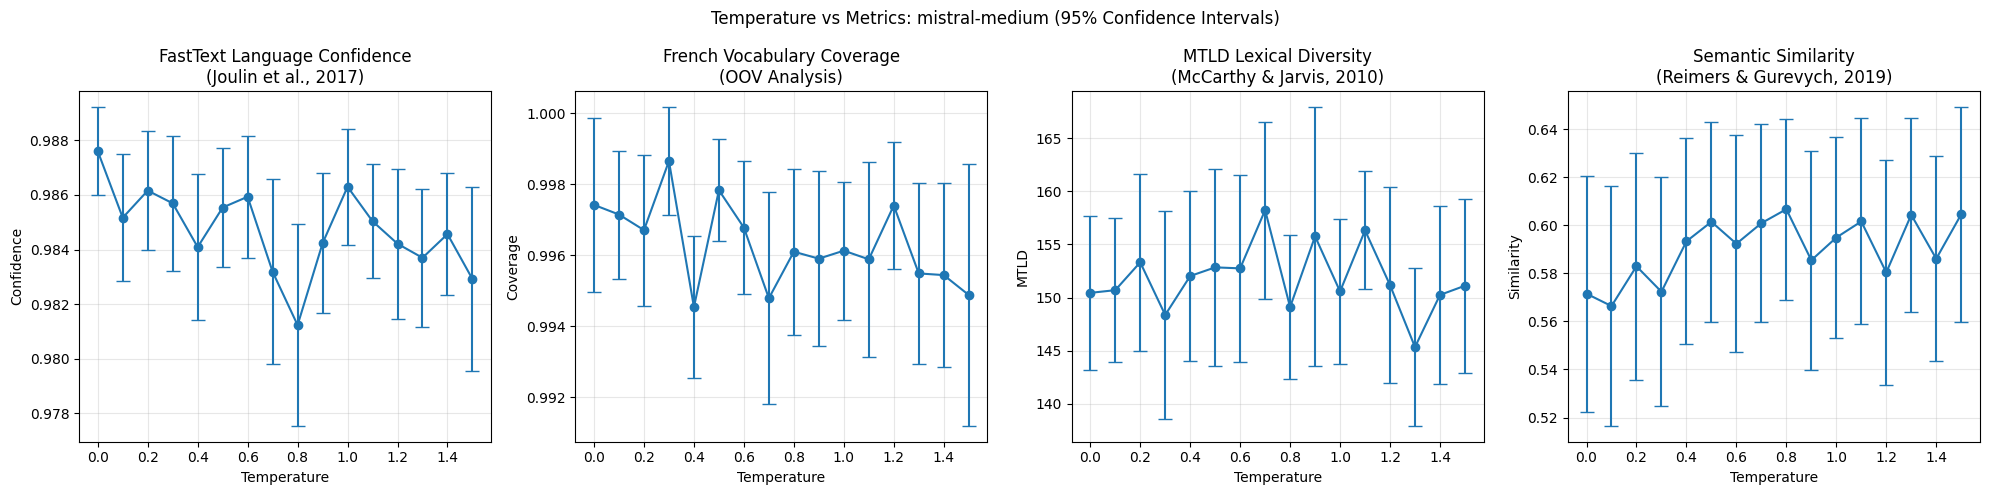

In [11]:
fig, axes = plot_single_model_metrics(temp_stats_mistral, "mistral-medium", use_ci=True)
plt.show()

## claude-sonnet-4

In [12]:
with open('results/results_anthropic.json', 'r', encoding='utf-8') as f:
    raw_data_anthropic = json.load(f)

df_anthropic = pd.DataFrame(raw_data_anthropic)
df_anthropic = df_anthropic[df_anthropic['iteration'] <= 10]  # Filter to match other models
analysis_df_anthropic = process_model_data(df_anthropic, sbert_model, "Anthropic")
temp_stats_anthropic = calculate_temperature_stats(analysis_df_anthropic)

Processing 330 samples for Anthropic...
  Processed 0/330 samples...
  Processed 100/330 samples...
  Processed 200/330 samples...
  Processed 300/330 samples...
✓ Analyzed 330 samples for Anthropic
  Temperature distribution: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


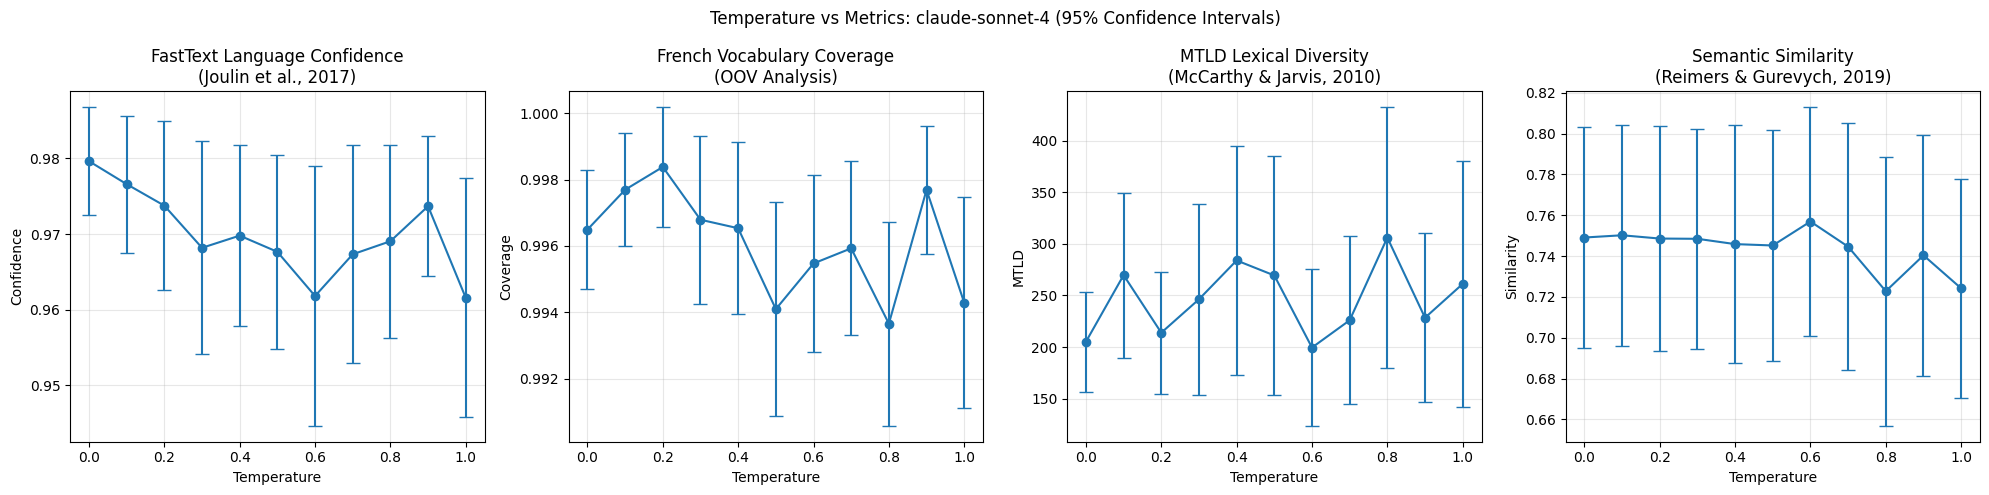

In [13]:
fig, axes = plot_single_model_metrics(temp_stats_anthropic, "claude-sonnet-4", use_ci=True)
plt.show()

## Combined visualization

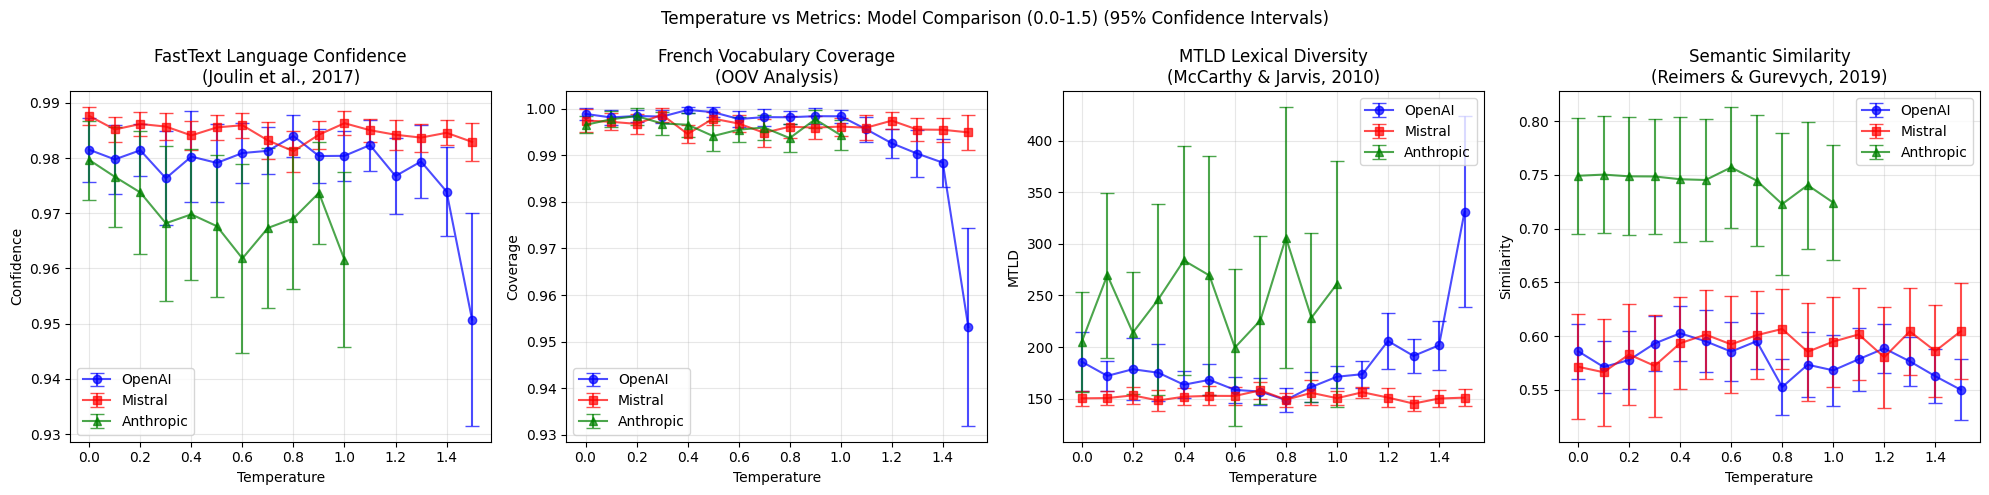

=== MODEL COMPARISON SUMMARY ===
OpenAI: 21 temperature points, 30 samples each
Mistral: 16 temperature points, 30 samples each
Anthropic: 11 temperature points, 30 samples each
Temperature range: 0.0 - 1.5
Error bars: 95% Confidence Intervals


In [15]:
from text_analysis import plot_combined_models_metrics

# Define models data with consistent sample sizes and styling
models_data = {
    'OpenAI': {
        'temp_stats': temp_stats_openai,
        'sample_size': 30,
        'color': 'blue',
        'marker': 'o'
    },
    'Mistral': {
        'temp_stats': temp_stats_mistral,
        'sample_size': 30,
        'color': 'red', 
        'marker': 's'
    },
    'Anthropic': {
        'temp_stats': temp_stats_anthropic,
        'sample_size': 30,
        'color': 'green',
        'marker': '^'
    }
}

# Combined visualization with 95% confidence intervals (temperature 0.0-1.5)
fig, axes = plot_combined_models_metrics(
    models_data, 
    temp_range=(0.0, 1.5), 
    use_ci=True
)
plt.show()

# Print comparison summary
print("=== MODEL COMPARISON SUMMARY ===")
for model_name, model_info in models_data.items():
    temp_stats = model_info['temp_stats']
    if 'temp_range' in locals():
        temp_stats_filtered = temp_stats[
            (temp_stats['temperature'] >= 0.0) & 
            (temp_stats['temperature'] <= 1.5)
        ]
    else:
        temp_stats_filtered = temp_stats
    
    print(f"{model_name}: {len(temp_stats_filtered)} temperature points, {model_info['sample_size']} samples each")

print(f"Temperature range: 0.0 - 1.5")
print(f"Error bars: 95% Confidence Intervals")

## Load analysis tools

In [3]:
def simple_analysis(row):
    text = row if isinstance(row, str) else row.get('text', '')
    
    # STEP 1: CLEAN TEXT
    text = clean_text(text)
    
    # STEP 2: METRIC Language confidence
    detected_lang, lang_confidence = get_language_confidence(text)
    
    # STEP 3: METRIC Vocabulary coverage  
    vocab_coverage = get_vocabulary_coverage(text)
    
    # STEP 4: METRIC MTLD
    mtld_score = calculate_mtld(text)
    
    # STEP 5: METRIC Semantic similarity
    semantic_similarity = 0.0
    if not isinstance(row, str):
        prompt = row.get('user_prompt', '')
        if prompt.strip() and text.strip():
            try:
                # Use the already-loaded global model
                embeddings = sbert_model.encode([prompt, text])
                semantic_similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
                semantic_similarity = max(0.0, float(semantic_similarity))
            except Exception as e:
                print(f"Error: {e}")
                semantic_similarity = 0.0
    
    return {
        'language_confidence': lang_confidence,
        'vocab_coverage': vocab_coverage, 
        'mtld': mtld_score,
        'semantic_similarity': semantic_similarity
    }

In [5]:
results_openai = []
for i, row in df_openai.iterrows():
    metrics = simple_analysis(row)  # Pass entire row, not row['text']
    if metrics:
        ordered_metrics = {
            'temperature': row['temperature'],
            'iteration': row['iteration'],
            'language_confidence': metrics['language_confidence'],
            'vocab_coverage': metrics['vocab_coverage'],
            'mtld': metrics['mtld'],
            'semantic_similarity': metrics['semantic_similarity']
        }
        results_openai.append(ordered_metrics)

analysis_df_openai = pd.DataFrame(results_openai)

# Sort by temperature (low to high)
analysis_df_openai = analysis_df_openai.sort_values('temperature').reset_index(drop=True)

print(f"Analyzed {len(analysis_df_openai)} samples")
print(f"Temperature distribution in sample: {sorted(analysis_df_openai['temperature'].unique())}")
analysis_df_openai.head(10)

Analyzed 630 samples
Temperature distribution in sample: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


,temperature,iteration,language_confidence,vocab_coverage,mtld,semantic_similarity
0,0.0,1,0.987874,1.0,129.960000,0.707951
1,0.0,10,0.994441,1.0,176.505000,0.528125
2,0.0,9,0.992323,1.0,215.264000,0.474778
3,0.0,8,0.991537,1.0,179.210769,0.504186
4,0.0,7,0.993113,1.0,219.343158,0.477754
5,0.0,6,0.993588,1.0,215.053333,0.512447
6,0.0,5,0.989170,1.0,175.259259,0.434028
7,0.0,4,0.995942,1.0,127.905806,0.603449
8,0.0,2,0.994593,1.0,186.340000,0.508847
9,0.0,1,0.992330,1.0,159.454815,0.547247


## Visualise analysis

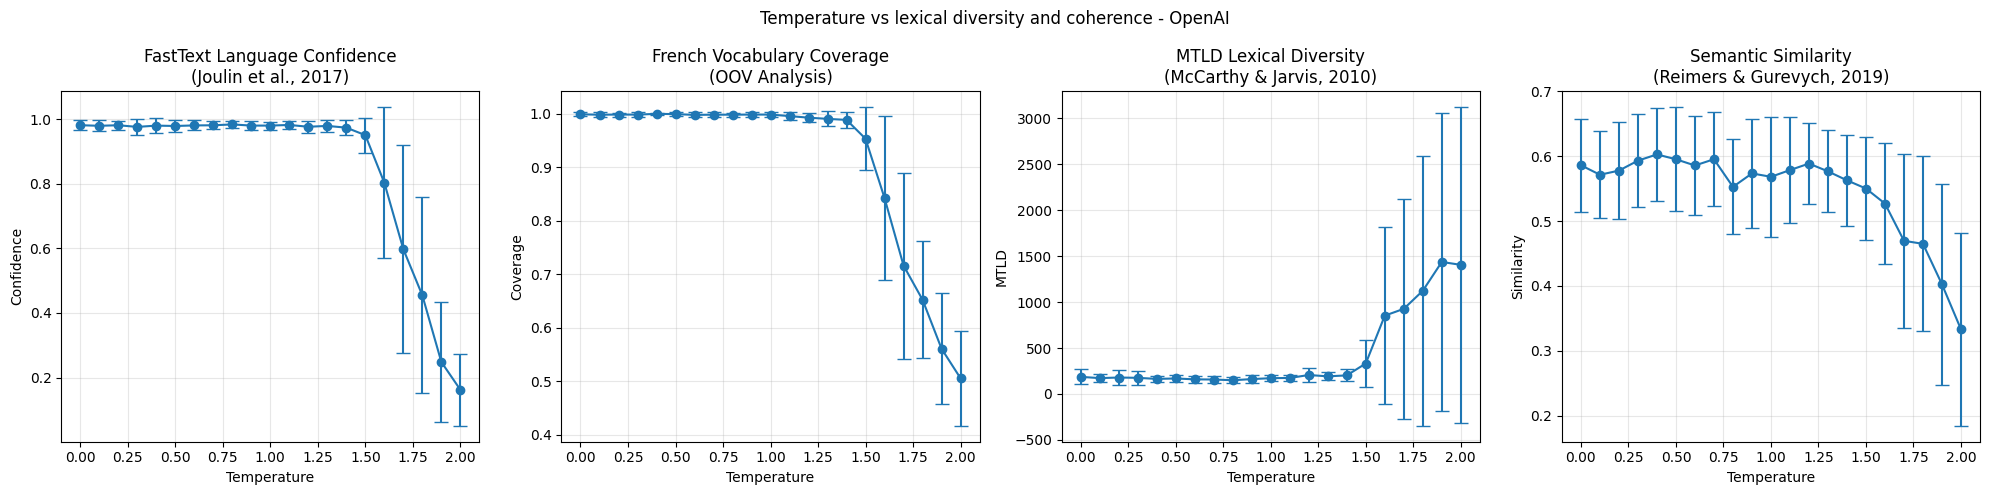

In [6]:
# Scientifically validated metrics only - NO ad-hoc composites
temp_stats_openai = analysis_df_openai.groupby('temperature').agg({
    'language_confidence': ['mean', 'std'],  # FastText (Joulin et al., 2017)
    'vocab_coverage': ['mean', 'std'],       # OOV analysis (standard NLP)
    'mtld': ['mean', 'std'],                 # MTLD (McCarthy & Jarvis, 2010)
    'semantic_similarity': ['mean', 'std']   # Sentence-BERT (Reimers & Gurevych, 2019)
}).reset_index()

# Flatten column names
temp_stats_openai.columns = ['temperature', 'lang_conf_mean', 'lang_conf_std', 
                     'vocab_mean', 'vocab_std', 'mtld_mean', 'mtld_std',
                     'semantic_mean', 'semantic_std']

# Create plots with ONLY scientifically backed metrics
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Temperature vs lexical diversity and coherence - OpenAI')

# Language confidence (FastText - Joulin et al., 2017)
axes[0].errorbar(temp_stats_openai['temperature'], temp_stats_openai['lang_conf_mean'], 
                 yerr=temp_stats_openai['lang_conf_std'], marker='o', capsize=5)
axes[0].set_title('FastText Language Confidence\n(Joulin et al., 2017)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Confidence')
axes[0].grid(True, alpha=0.3)

# Vocabulary coverage (OOV analysis)
axes[1].errorbar(temp_stats_openai['temperature'], temp_stats_openai['vocab_mean'], 
                 yerr=temp_stats_openai['vocab_std'], marker='o', capsize=5)
axes[1].set_title('French Vocabulary Coverage\n(OOV Analysis)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Coverage')
axes[1].grid(True, alpha=0.3)

# MTLD (McCarthy & Jarvis, 2010)
axes[2].errorbar(temp_stats_openai['temperature'], temp_stats_openai['mtld_mean'], 
                 yerr=temp_stats_openai['mtld_std'], marker='o', capsize=5)
axes[2].set_title('MTLD Lexical Diversity\n(McCarthy & Jarvis, 2010)')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('MTLD')
axes[2].grid(True, alpha=0.3)

# Semantic similarity (Reimers & Gurevych, 2019)
axes[3].errorbar(temp_stats_openai['temperature'], temp_stats_openai['semantic_mean'], 
                 yerr=temp_stats_openai['semantic_std'], marker='o', capsize=5)
axes[3].set_title('Semantic Similarity\n(Reimers & Gurevych, 2019)')
axes[3].set_xlabel('Temperature')
axes[3].set_ylabel('Similarity')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show the aggregated data
# print("Temperature Statistics (Scientifically Validated Metrics Only):")
# print(temp_stats_openai.round(3))

## Mistral batch

In [7]:
# Load data
with open('results/results_mistral.json', 'r', encoding='utf-8') as f:
    raw_data_mistral = json.load(f)

df_mistral = pd.DataFrame(raw_data_mistral)
print(f"Loaded {len(df_mistral)} samples")
print(f"Temperature range: {df_mistral['temperature'].min():.1f} - {df_mistral['temperature'].max():.1f}")
df_mistral.head()

Loaded 480 samples
Temperature range: 0.0 - 1.5


,prompt_label,user_prompt,temperature,iteration,text
0,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,1,**a encore le temps de tout gâcher avant l’aub...
1,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,2,"**peut vraiment tout se dire, même les choses ..."
2,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,3,"**peut vraiment tout se dire, même les choses ..."
3,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,4,**peut vraiment tout laisser derrière nous ?**...
4,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,5,**a encore le temps de tout gâcher avant l’aub...


In [8]:
results_mistral = []
for i, row in df_mistral.iterrows():
    metrics = simple_analysis(row)  # Pass entire row, not row['text']
    if metrics:
        ordered_metrics = {
            'temperature': row['temperature'],
            'iteration': row['iteration'],
            'language_confidence': metrics['language_confidence'],
            'vocab_coverage': metrics['vocab_coverage'],
            'mtld': metrics['mtld'],
            'semantic_similarity': metrics['semantic_similarity']
        }
        results_mistral.append(ordered_metrics)

analysis_df_mistral = pd.DataFrame(results_mistral)

# Sort by temperature (low to high)
analysis_df_mistral = analysis_df_mistral.sort_values('temperature').reset_index(drop=True)

print(f"Analyzed {len(analysis_df_mistral)} samples")
print(f"Temperature distribution in sample: {sorted(analysis_df_mistral['temperature'].unique())}")
analysis_df_mistral.head(10)

Analyzed 480 samples
Temperature distribution in sample: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]


,temperature,iteration,language_confidence,vocab_coverage,mtld,semantic_similarity
0,0.0,1,0.985647,1.000000,136.718750,0.448936
1,0.0,10,0.988931,1.000000,136.890000,0.752501
2,0.0,9,0.986089,1.000000,159.650909,0.739459
3,0.0,8,0.986524,1.000000,144.638261,0.747866
4,0.0,7,0.993657,1.000000,140.492800,0.745673
5,0.0,6,0.982444,0.990826,163.296000,0.777448
6,0.0,5,0.992859,1.000000,140.492800,0.745673
7,0.0,4,0.982444,0.990826,163.296000,0.777448
8,0.0,3,0.969909,1.000000,138.611667,0.761230
9,0.0,1,0.990188,1.000000,151.212727,0.752501


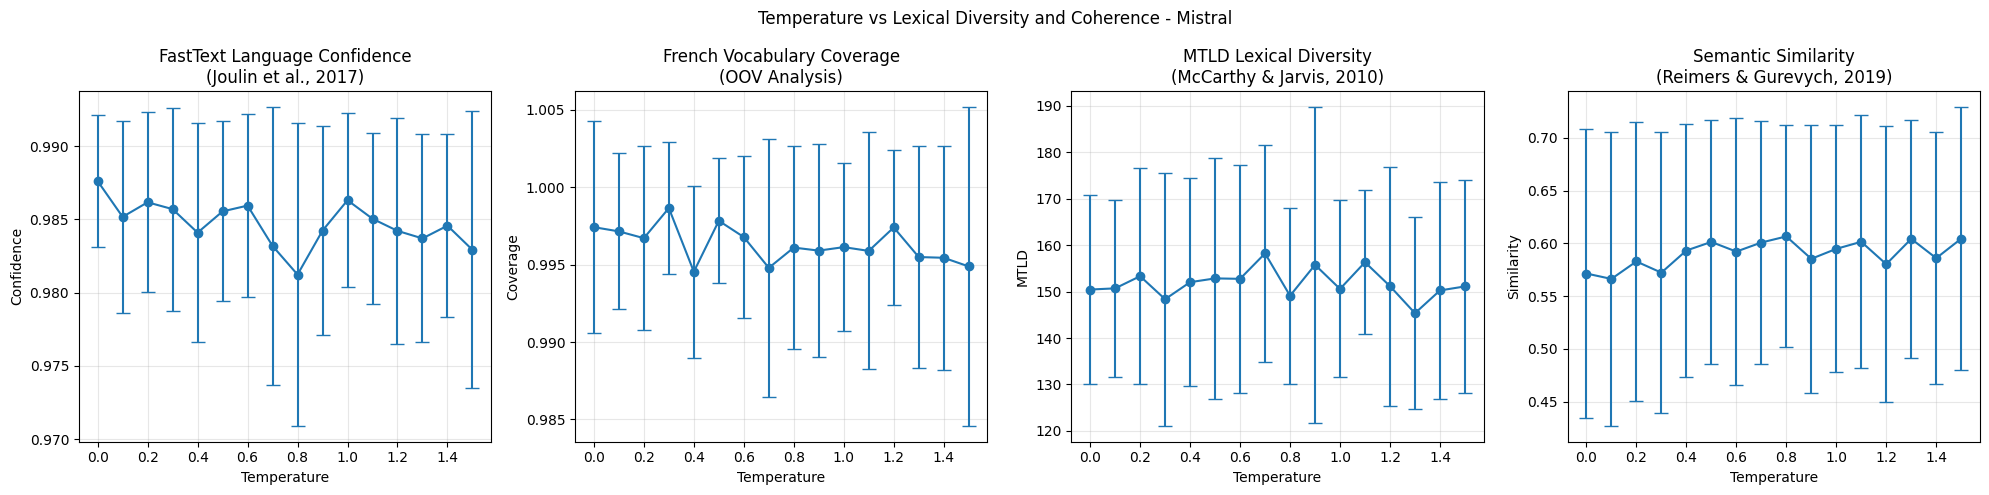

In [9]:
temp_stats_mistral = analysis_df_mistral.groupby('temperature').agg({
    'language_confidence': ['mean', 'std'],  # FastText (Joulin et al., 2017)
    'vocab_coverage': ['mean', 'std'],       # OOV analysis (standard NLP)
    'mtld': ['mean', 'std'],                 # MTLD (McCarthy & Jarvis, 2010)
    'semantic_similarity': ['mean', 'std']   # Sentence-BERT (Reimers & Gurevych, 2019)
}).reset_index()

# Flatten column names
temp_stats_mistral.columns = ['temperature', 'lang_conf_mean', 'lang_conf_std', 
                     'vocab_mean', 'vocab_std', 'mtld_mean', 'mtld_std',
                     'semantic_mean', 'semantic_std']

# Create plots with ONLY scientifically backed metrics
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Temperature vs Lexical Diversity and Coherence - Mistral')

# Language confidence (FastText - Joulin et al., 2017)
axes[0].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['lang_conf_mean'], 
                 yerr=temp_stats_mistral['lang_conf_std'], marker='o', capsize=5)
axes[0].set_title('FastText Language Confidence\n(Joulin et al., 2017)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Confidence')
axes[0].grid(True, alpha=0.3)

# Vocabulary coverage (OOV analysis)
axes[1].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['vocab_mean'], 
                 yerr=temp_stats_mistral['vocab_std'], marker='o', capsize=5)
axes[1].set_title('French Vocabulary Coverage\n(OOV Analysis)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Coverage')
axes[1].grid(True, alpha=0.3)

# MTLD (McCarthy & Jarvis, 2010)
axes[2].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['mtld_mean'], 
                 yerr=temp_stats_mistral['mtld_std'], marker='o', capsize=5)
axes[2].set_title('MTLD Lexical Diversity\n(McCarthy & Jarvis, 2010)')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('MTLD')
axes[2].grid(True, alpha=0.3)

# Semantic similarity (Reimers & Gurevych, 2019)
axes[3].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['semantic_mean'], 
                 yerr=temp_stats_mistral['semantic_std'], marker='o', capsize=5)
axes[3].set_title('Semantic Similarity\n(Reimers & Gurevych, 2019)')
axes[3].set_xlabel('Temperature')
axes[3].set_ylabel('Similarity')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show the aggregated data
# print("Temperature Statistics (Scientifically Validated Metrics Only):")
# print(temp_stats.round(3))

In [ ]:
## Combined Analysis - OpenAI vs Mistral Overlay (Limited to temp ≤ 1.5)

# Filter OpenAI data to match Mistral's temperature range (0.0-1.5)
temp_stats_filtered = temp_stats[temp_stats['temperature'] <= 1.5].copy()

# Create combined visualization with both models (limited range)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Temperature vs Metrics: OpenAI vs Mistral Comparison (0.0-1.5)')

# Language confidence comparison
axes[0].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['lang_conf_mean'], 
                 yerr=temp_stats_filtered['lang_conf_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[0].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['lang_conf_mean'], 
                 yerr=temp_stats_mistral['lang_conf_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[0].set_title('FastText Language Confidence\n(Joulin et al., 2017)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Confidence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Vocabulary coverage comparison
axes[1].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['vocab_mean'], 
                 yerr=temp_stats_filtered['vocab_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[1].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['vocab_mean'], 
                 yerr=temp_stats_mistral['vocab_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[1].set_title('French Vocabulary Coverage\n(OOV Analysis)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Coverage')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MTLD comparison
axes[2].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['mtld_mean'], 
                 yerr=temp_stats_filtered['mtld_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[2].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['mtld_mean'], 
                 yerr=temp_stats_mistral['mtld_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[2].set_title('MTLD Lexical Diversity\n(McCarthy & Jarvis, 2010)')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('MTLD')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Semantic similarity comparison
axes[3].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['semantic_mean'], 
                 yerr=temp_stats_filtered['semantic_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[3].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['semantic_mean'], 
                 yerr=temp_stats_mistral['semantic_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[3].set_title('Semantic Similarity\n(Reimers & Gurevych, 2019)')
axes[3].set_xlabel('Temperature')
axes[3].set_ylabel('Similarity')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for comparison
print("=== MODEL COMPARISON SUMMARY (Temperature ≤ 1.5) ===")
print(f"OpenAI samples: {len(temp_stats_filtered)} temperature points")
print(f"Mistral samples: {len(temp_stats_mistral)} temperature points")
print(f"Temperature range: 0.0 - 1.5")
print(f"Temperature points: {sorted(temp_stats_filtered['temperature'].unique())}")

## Anthropic

In [10]:
# Load data
with open('results/results_anthropic.json', 'r', encoding='utf-8') as f:
    raw_data_anthropic = json.load(f)

df_anthropic = pd.DataFrame(raw_data_anthropic)
print(f"Loaded {len(df_anthropic)} samples")
print(f"Temperature range: {df_anthropic['temperature'].min():.1f} - {df_anthropic['temperature'].max():.1f}")
df_anthropic.head(-10)

Loaded 330 samples
Temperature range: 0.0 - 1.0


,prompt_label,user_prompt,temperature,iteration,text
0,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,1,Elio : Tu crois qu'on peut vraiment revenir en...
1,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,2,Elio : Tu crois qu'on peut vraiment revenir en...
2,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,3,Elio : Tu crois qu'on peut vraiment revenir en...
3,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,4,Elio : Tu crois qu'on peut vraiment revenir en...
4,dialog,INT. CUISINE — NUIT. Les deux personnages se f...,0.0,5,Elio : Tu crois qu'on peut vraiment revenir en...
...,...,...,...,...,...
315,storyboard,"Storyboard — générique, 1–4 : (1) Faisceau pro...",1.0,6,"Storyboard — générique, 1–4 : (1) Faisceau pro..."
316,storyboard,"Storyboard — générique, 1–4 : (1) Faisceau pro...",1.0,7,"Storyboard — générique, 1–4 : (1) Faisceau pro..."
317,storyboard,"Storyboard — générique, 1–4 : (1) Faisceau pro...",1.0,8,"Storyboard — générique, 1–4 : (1) Faisceau pro..."
318,storyboard,"Storyboard — générique, 1–4 : (1) Faisceau pro...",1.0,9,"**Storyboard — générique, 1–4 :**\n\n(1) Faisc..."


In [11]:
results_anthropic = []
for i, row in df_anthropic.iterrows():
    metrics = simple_analysis(row)  # Pass entire row, not row['text']
    if metrics:
        ordered_metrics = {
            'temperature': row['temperature'],
            'iteration': row['iteration'],
            'language_confidence': metrics['language_confidence'],
            'vocab_coverage': metrics['vocab_coverage'],
            'mtld': metrics['mtld'],
            'semantic_similarity': metrics['semantic_similarity']
        }
        results_anthropic.append(ordered_metrics)

analysis_df_anthropic = pd.DataFrame(results_anthropic)

# Sort by temperature (low to high)
analysis_df_anthropic = analysis_df_anthropic.sort_values('temperature').reset_index(drop=True)

print(f"Analyzed {len(analysis_df_anthropic)} samples")
print(f"Temperature distribution in sample: {sorted(analysis_df_anthropic['temperature'].unique())}")
analysis_df_anthropic.head(10)

Analyzed 330 samples
Temperature distribution in sample: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


,temperature,iteration,language_confidence,vocab_coverage,mtld,semantic_similarity
0,0.0,1,0.996090,1.000000,171.517500,0.575282
1,0.0,10,0.990755,0.989474,129.153043,0.733788
2,0.0,9,0.990755,0.989474,129.153043,0.733788
3,0.0,8,0.990755,0.989474,129.153043,0.733788
4,0.0,7,0.990755,0.989474,129.153043,0.733788
5,0.0,6,0.990755,0.989474,129.153043,0.733788
6,0.0,5,0.990755,0.989474,129.153043,0.733788
7,0.0,4,0.990755,0.989474,129.153043,0.733788
8,0.0,2,0.990755,0.989474,129.153043,0.733788
9,0.0,1,0.990755,0.989474,129.153043,0.733788


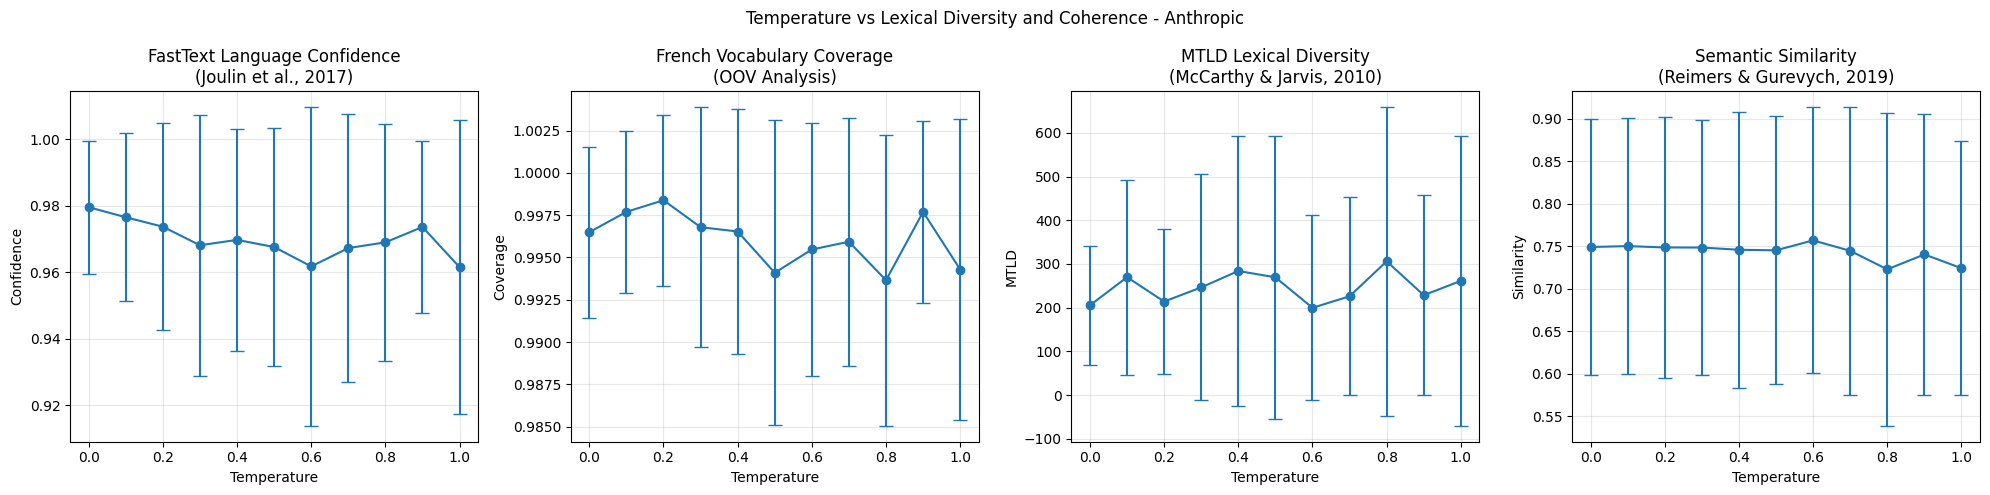

In [12]:
temp_stats_anthropic = analysis_df_anthropic.groupby('temperature').agg({
    'language_confidence': ['mean', 'std'],  # FastText (Joulin et al., 2017)
    'vocab_coverage': ['mean', 'std'],       # OOV analysis (standard NLP)
    'mtld': ['mean', 'std'],                 # MTLD (McCarthy & Jarvis, 2010)
    'semantic_similarity': ['mean', 'std']   # Sentence-BERT (Reimers & Gurevych, 2019)
}).reset_index()

# Flatten column names
temp_stats_anthropic.columns = ['temperature', 'lang_conf_mean', 'lang_conf_std', 
                     'vocab_mean', 'vocab_std', 'mtld_mean', 'mtld_std',
                     'semantic_mean', 'semantic_std']

# Create plots with ONLY scientifically backed metrics
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Temperature vs Lexical Diversity and Coherence - Anthropic')

# Language confidence (FastText - Joulin et al., 2017)
axes[0].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['lang_conf_mean'], 
                 yerr=temp_stats_anthropic['lang_conf_std'], marker='o', capsize=5)
axes[0].set_title('FastText Language Confidence\n(Joulin et al., 2017)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Confidence')
axes[0].grid(True, alpha=0.3)

# Vocabulary coverage (OOV analysis)
axes[1].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['vocab_mean'], 
                 yerr=temp_stats_anthropic['vocab_std'], marker='o', capsize=5)
axes[1].set_title('French Vocabulary Coverage\n(OOV Analysis)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Coverage')
axes[1].grid(True, alpha=0.3)

# MTLD (McCarthy & Jarvis, 2010)
axes[2].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['mtld_mean'], 
                 yerr=temp_stats_anthropic['mtld_std'], marker='o', capsize=5)
axes[2].set_title('MTLD Lexical Diversity\n(McCarthy & Jarvis, 2010)')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('MTLD')
axes[2].grid(True, alpha=0.3)

# Semantic similarity (Reimers & Gurevych, 2019)
axes[3].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['semantic_mean'], 
                 yerr=temp_stats_anthropic['semantic_std'], marker='o', capsize=5)
axes[3].set_title('Semantic Similarity\n(Reimers & Gurevych, 2019)')
axes[3].set_xlabel('Temperature')
axes[3].set_ylabel('Similarity')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Combined analysis

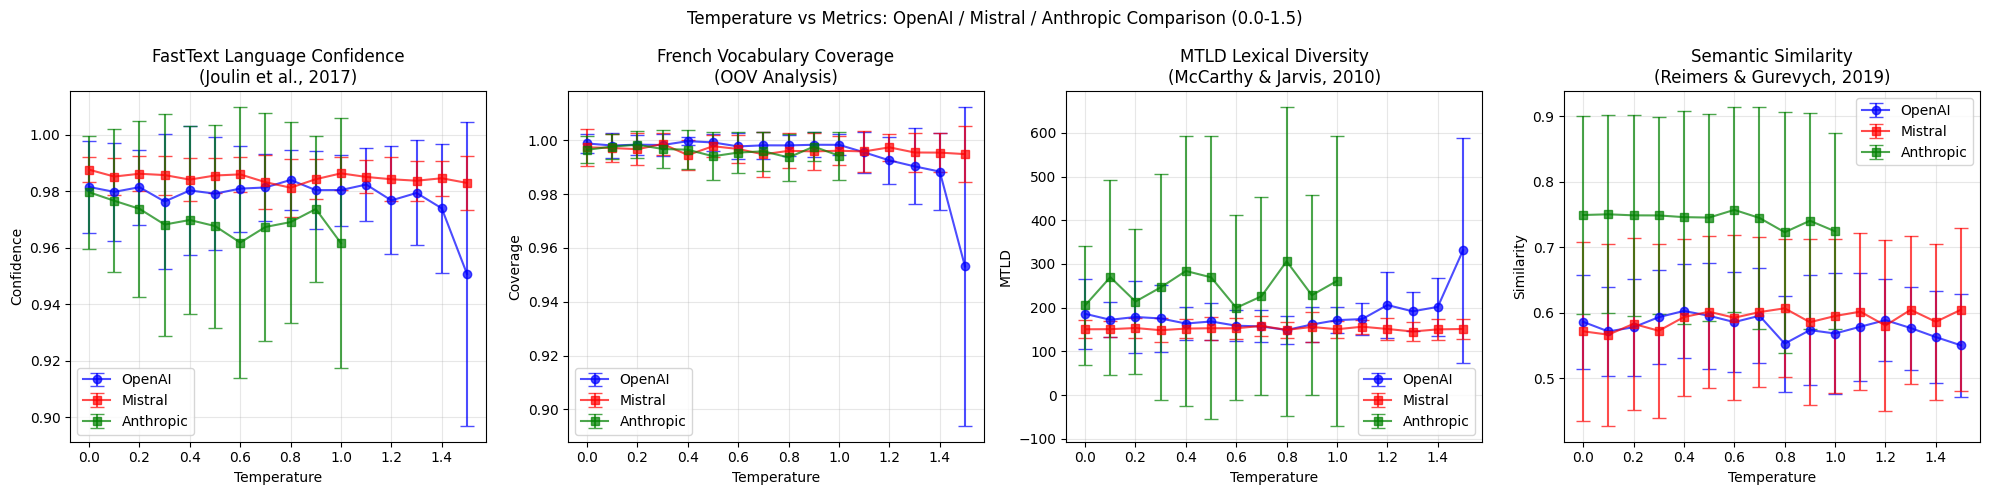

=== MODEL COMPARISON SUMMARY (Temperature ≤ 1.5) ===
OpenAI samples: 16 temperature points
Mistral samples: 16 temperature points
Temperature range: 0.0 - 1.5
Temperature points: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]


In [13]:
## Combined Analysis - OpenAI vs Mistral Overlay (Limited to temp ≤ 1.5)

# Filter OpenAI data to match Mistral's temperature range (0.0-1.5)
temp_stats_filtered = temp_stats_openai[temp_stats_openai['temperature'] <= 1.5].copy()

# Create combined visualization with both models (limited range)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Temperature vs Metrics: OpenAI / Mistral / Anthropic Comparison (0.0-1.5)')

# Language confidence comparison
axes[0].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['lang_conf_mean'], 
                 yerr=temp_stats_filtered['lang_conf_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[0].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['lang_conf_mean'], 
                 yerr=temp_stats_mistral['lang_conf_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[0].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['lang_conf_mean'], 
                 yerr=temp_stats_anthropic['lang_conf_std'], marker='s', capsize=5, 
                 label='Anthropic', color='green', alpha=0.7)
axes[0].set_title('FastText Language Confidence\n(Joulin et al., 2017)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Confidence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Vocabulary coverage comparison
axes[1].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['vocab_mean'], 
                 yerr=temp_stats_filtered['vocab_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[1].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['vocab_mean'], 
                 yerr=temp_stats_mistral['vocab_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[1].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['vocab_mean'], 
                 yerr=temp_stats_anthropic['vocab_std'], marker='s', capsize=5, 
                 label='Anthropic', color='green', alpha=0.7)
axes[1].set_title('French Vocabulary Coverage\n(OOV Analysis)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Coverage')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MTLD comparison
axes[2].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['mtld_mean'], 
                 yerr=temp_stats_filtered['mtld_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[2].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['mtld_mean'], 
                 yerr=temp_stats_mistral['mtld_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[2].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['mtld_mean'], 
                 yerr=temp_stats_anthropic['mtld_std'], marker='s', capsize=5, 
                 label='Anthropic', color='green', alpha=0.7)
axes[2].set_title('MTLD Lexical Diversity\n(McCarthy & Jarvis, 2010)')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('MTLD')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Semantic similarity comparison
axes[3].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['semantic_mean'], 
                 yerr=temp_stats_filtered['semantic_std'], marker='o', capsize=5, 
                 label='OpenAI', color='blue', alpha=0.7)
axes[3].errorbar(temp_stats_mistral['temperature'], temp_stats_mistral['semantic_mean'], 
                 yerr=temp_stats_mistral['semantic_std'], marker='s', capsize=5, 
                 label='Mistral', color='red', alpha=0.7)
axes[3].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['semantic_mean'], 
                 yerr=temp_stats_anthropic['semantic_std'], marker='s', capsize=5, 
                 label='Anthropic', color='green', alpha=0.7)
axes[3].set_title('Semantic Similarity\n(Reimers & Gurevych, 2019)')
axes[3].set_xlabel('Temperature')
axes[3].set_ylabel('Similarity')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for comparison
print("=== MODEL COMPARISON SUMMARY (Temperature ≤ 1.5) ===")
print(f"OpenAI samples: {len(temp_stats_filtered)} temperature points")
print(f"Mistral samples: {len(temp_stats_mistral)} temperature points")
print(f"Temperature range: 0.0 - 1.5")
print(f"Temperature points: {sorted(temp_stats_filtered['temperature'].unique())}")

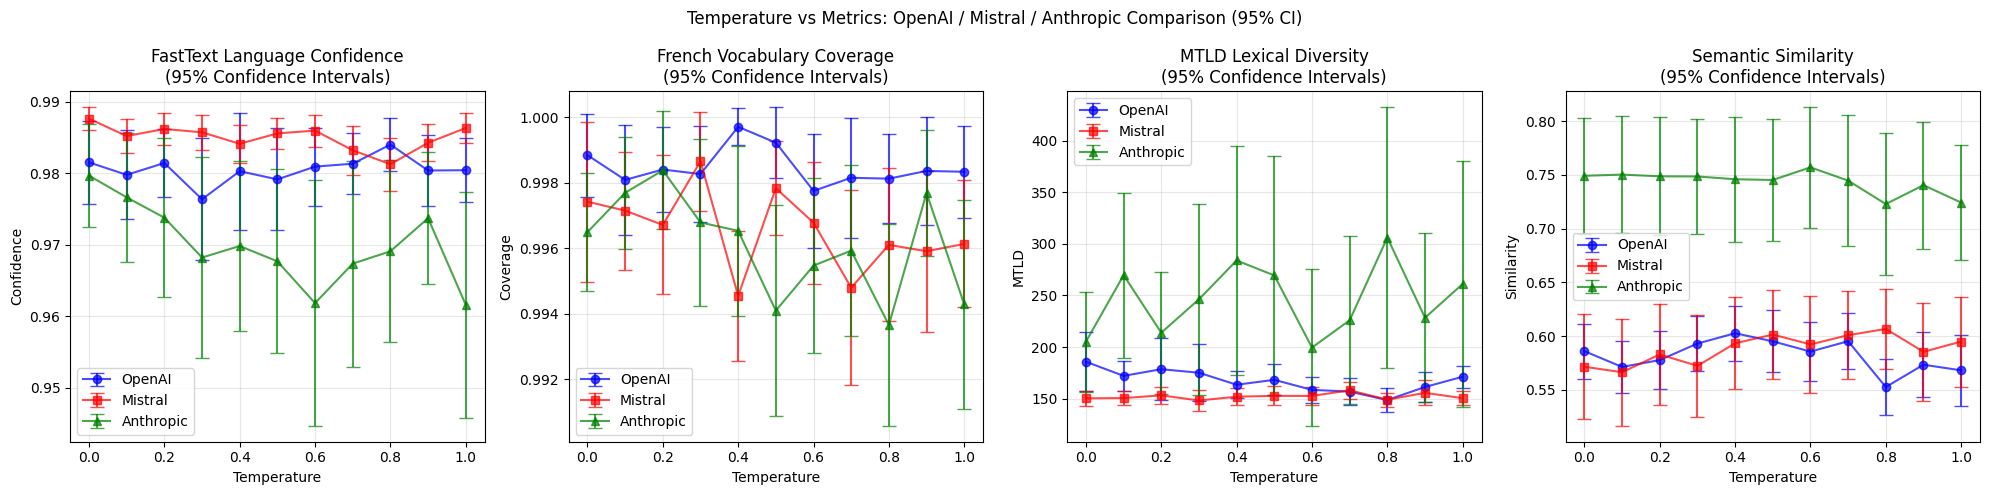

=== MODEL COMPARISON SUMMARY (Temperature 0.0-1.0, 95% CI) ===
OpenAI samples: 11 temperature points, 30 samples each
Mistral samples: 11 temperature points, 30 samples each
Anthropic samples: 11 temperature points, 30 samples each
Temperature range: 0.0 - 1.0
Confidence intervals show 95% likelihood range for true mean values


In [14]:
import numpy as np

## Combined Analysis - OpenAI vs Mistral vs Anthropic with 95% Confidence Intervals

# Filter OpenAI data to match comparison range (0.0-1.0 for all models)
temp_stats_filtered = temp_stats_openai[temp_stats_openai['temperature'] <= 1.0].copy()
temp_stats_mistral_filtered = temp_stats_mistral[temp_stats_mistral['temperature'] <= 1.0].copy()

# Sample sizes for confidence interval calculation
n_openai = 30  # 30 samples per temperature
n_mistral = 30  # 30 samples per temperature  
n_anthropic = 30  # 30 samples per temperature (after filtering to iterations 1-10)

# Calculate 95% CI (1.96 * SEM = 1.96 * std/√n)
ci_multiplier = 1.96

# Create combined visualization with 95% confidence intervals
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Temperature vs Metrics: OpenAI / Mistral / Anthropic Comparison (95% CI)')

# Language confidence comparison
axes[0].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['lang_conf_mean'], 
                 yerr=ci_multiplier * temp_stats_filtered['lang_conf_std'] / np.sqrt(n_openai), 
                 marker='o', capsize=5, label='OpenAI', color='blue', alpha=0.7)
axes[0].errorbar(temp_stats_mistral_filtered['temperature'], temp_stats_mistral_filtered['lang_conf_mean'], 
                 yerr=ci_multiplier * temp_stats_mistral_filtered['lang_conf_std'] / np.sqrt(n_mistral), 
                 marker='s', capsize=5, label='Mistral', color='red', alpha=0.7)
axes[0].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['lang_conf_mean'], 
                 yerr=ci_multiplier * temp_stats_anthropic['lang_conf_std'] / np.sqrt(n_anthropic), 
                 marker='^', capsize=5, label='Anthropic', color='green', alpha=0.7)
axes[0].set_title('FastText Language Confidence\n(95% Confidence Intervals)')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Confidence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Vocabulary coverage comparison
axes[1].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['vocab_mean'], 
                 yerr=ci_multiplier * temp_stats_filtered['vocab_std'] / np.sqrt(n_openai), 
                 marker='o', capsize=5, label='OpenAI', color='blue', alpha=0.7)
axes[1].errorbar(temp_stats_mistral_filtered['temperature'], temp_stats_mistral_filtered['vocab_mean'], 
                 yerr=ci_multiplier * temp_stats_mistral_filtered['vocab_std'] / np.sqrt(n_mistral), 
                 marker='s', capsize=5, label='Mistral', color='red', alpha=0.7)
axes[1].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['vocab_mean'], 
                 yerr=ci_multiplier * temp_stats_anthropic['vocab_std'] / np.sqrt(n_anthropic), 
                 marker='^', capsize=5, label='Anthropic', color='green', alpha=0.7)
axes[1].set_title('French Vocabulary Coverage\n(95% Confidence Intervals)')
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Coverage')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MTLD comparison
axes[2].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['mtld_mean'], 
                 yerr=ci_multiplier * temp_stats_filtered['mtld_std'] / np.sqrt(n_openai), 
                 marker='o', capsize=5, label='OpenAI', color='blue', alpha=0.7)
axes[2].errorbar(temp_stats_mistral_filtered['temperature'], temp_stats_mistral_filtered['mtld_mean'], 
                 yerr=ci_multiplier * temp_stats_mistral_filtered['mtld_std'] / np.sqrt(n_mistral), 
                 marker='s', capsize=5, label='Mistral', color='red', alpha=0.7)
axes[2].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['mtld_mean'], 
                 yerr=ci_multiplier * temp_stats_anthropic['mtld_std'] / np.sqrt(n_anthropic), 
                 marker='^', capsize=5, label='Anthropic', color='green', alpha=0.7)
axes[2].set_title('MTLD Lexical Diversity\n(95% Confidence Intervals)')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('MTLD')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Semantic similarity comparison
axes[3].errorbar(temp_stats_filtered['temperature'], temp_stats_filtered['semantic_mean'], 
                 yerr=ci_multiplier * temp_stats_filtered['semantic_std'] / np.sqrt(n_openai), 
                 marker='o', capsize=5, label='OpenAI', color='blue', alpha=0.7)
axes[3].errorbar(temp_stats_mistral_filtered['temperature'], temp_stats_mistral_filtered['semantic_mean'], 
                 yerr=ci_multiplier * temp_stats_mistral_filtered['semantic_std'] / np.sqrt(n_mistral), 
                 marker='s', capsize=5, label='Mistral', color='red', alpha=0.7)
axes[3].errorbar(temp_stats_anthropic['temperature'], temp_stats_anthropic['semantic_mean'], 
                 yerr=ci_multiplier * temp_stats_anthropic['semantic_std'] / np.sqrt(n_anthropic), 
                 marker='^', capsize=5, label='Anthropic', color='green', alpha=0.7)
axes[3].set_title('Semantic Similarity\n(95% Confidence Intervals)')
axes[3].set_xlabel('Temperature')
axes[3].set_ylabel('Similarity')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for comparison
print("=== MODEL COMPARISON SUMMARY (Temperature 0.0-1.0, 95% CI) ===")
print(f"OpenAI samples: {len(temp_stats_filtered)} temperature points, {n_openai} samples each")
print(f"Mistral samples: {len(temp_stats_mistral_filtered)} temperature points, {n_mistral} samples each")
print(f"Anthropic samples: {len(temp_stats_anthropic)} temperature points, {n_anthropic} samples each")
print(f"Temperature range: 0.0 - 1.0")
print(f"Confidence intervals show 95% likelihood range for true mean values")